# Fraud Activity Detection

E-commerce websites often transact huge amounts of money. And whenever a huge amount of
money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen
credit cards, doing money laundry, et?.

Machine Learning really excels at identifying fraudulent activities. Any website where you put
your credit card information has a risk team in charge of avoiding frauds via machine learning.
The goal of this challenge is to build a machine learning model that predicts the probability that
the first transaction of a new user is fraudulent.


## Detail Description
Company XYZ is an e-commerce site that sells hand-made clothes.

You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.

You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").

1. For each user, determine her country based on the numeric IP address.
2. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model. Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
3. Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

## Read in data and take look at data structure

In [1]:
# Importing a few necessary libraries
import numpy as np
import math  as math
import pandas as pd
from sklearn import linear_model
from sklearn import preprocessing
import re
import sys

from IPython.display import display

try: 
    fraud_data = pd.read_csv('../data/Fraud_Data.csv')
    ip_data = pd.read_csv('../data/IpAddress_to_Country.csv')
    print "Import Data Succesful"
except:
    print "Unexpected error:", sys.exc_info()[0]

Import Data Succesful


In [2]:
display(fraud_data.head())
display(ip_data.head())

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Feature Engineering

1. time diffrence between sign_up and purchase time
2. if the device id is unique or certain users are sharing the same device(many different user ids using the same device could be an indicator of fake accounts)
3. same for the ip address. many different users having the same ip address could be a indicator of fake account.
4. usual week of the year and day the week from time variables

In [3]:
#add country to fraud_data table
new_features = pd.DataFrame(
    columns=['user_id', 'country'])
for index, row in fraud_data.iterrows():
    temp_ip_data = ip_data[(ip_data.lower_bound_ip_address <= row['ip_address']) 
                         & (ip_data.upper_bound_ip_address >= row['ip_address'])]
    if temp_ip_data['country'].empty :
        temp_country = 'NA'
    else:
        temp_country = [row1['country'] for index1, row1 in temp_ip_data.iterrows()][0]
    new_features = new_features.append(
        pd.DataFrame([[row['user_id'],temp_country]],
                                      columns = ['user_id', 'country']))
fraud_data = pd.merge(fraud_data, new_features, on='user_id')


#convert datetime object to datetime format
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

#time diffrence between sign_up and purchase time
fraud_data['sigup_purchase_time_diff'] = fraud_data['purchase_time'] - fraud_data['signup_time']
fraud_data['sigup_purchase_time_diff'] = fraud_data['sigup_purchase_time_diff'].dt.seconds

#for each device id how many different user use it
num_user_by_device = fraud_data[['user_id','device_id']].groupby('device_id').count()
num_user_by_device = num_user_by_device.reset_index(level=['user_id'])
num_user_by_device=num_user_by_device.rename(columns = {'user_id':'users_by_device'})
fraud_data = pd.merge(fraud_data,num_user_by_device, on='device_id')

#for each ip address how many different user had it
num_user_by_ip = fraud_data[['user_id','ip_address']].groupby('ip_address').count()
num_user_by_ip = num_user_by_ip.reset_index(level=['user_id'])
num_user_by_ip = num_user_by_ip.rename(columns = {'user_id':'users_by_ip'})
fraud_data = pd.merge(fraud_data,num_user_by_ip, on='ip_address')

#day of the week
fraud_data['signup_time_wd'] = fraud_data['signup_time'].dt.dayofweek
fraud_data['purchase_time_wd'] = fraud_data['purchase_time'].dt.dayofweek

#week of the yr
fraud_data['signup_time_wy'] = fraud_data['signup_time'].dt.week
fraud_data['purchase_time_wy'] = fraud_data['purchase_time'].dt.week

#hour of the day
fraud_data['signip_time_hr'] = fraud_data['signup_time'].dt.hour
fraud_data['purchase_time_hr'] = fraud_data['purchase_time'].dt.hour

print "Feature Pre-processing finished"

Feature Pre-processing finished


In [4]:
display(fraud_data.head())
display(fraud_data.columns)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,country,sigup_purchase_time_diff,users_by_device,users_by_ip,signup_time_wd,purchase_time_wd,signup_time_wy,purchase_time_wy,signip_time_hr,purchase_time_hr
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Japan,13882,1,1,1,5,9,16,22,2
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,United States,17944,1,1,6,0,23,24,20,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,United States,1,12,12,3,3,1,1,18,18
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,United States,1,12,12,3,3,1,1,18,18
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,United States,1,12,12,3,3,1,1,18,18


Index([u'user_id', u'signup_time', u'purchase_time', u'purchase_value',
       u'device_id', u'source', u'browser', u'sex', u'age', u'ip_address',
       u'class', u'country', u'sigup_purchase_time_diff', u'users_by_device',
       u'users_by_ip', u'signup_time_wd', u'purchase_time_wd',
       u'signup_time_wy', u'purchase_time_wy', u'signip_time_hr',
       u'purchase_time_hr'],
      dtype='object')

In [5]:
#keep the top 50 country and assign not top 50 as others
country_count = fraud_data[['country','user_id']].groupby('country').count()
country_count = country_count.reset_index(level=['user_id'])
country_count = country_count.rename(columns = {'user_id':'country_count'}).sort_values(by = 'country_count', ascending = False).head(50)
country_list = list(country_count['country'])

fraud_data['country'][fraud_data['country'].isin(country_list)== False] = 'Others'

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Visualization Data

### Attributes Plot

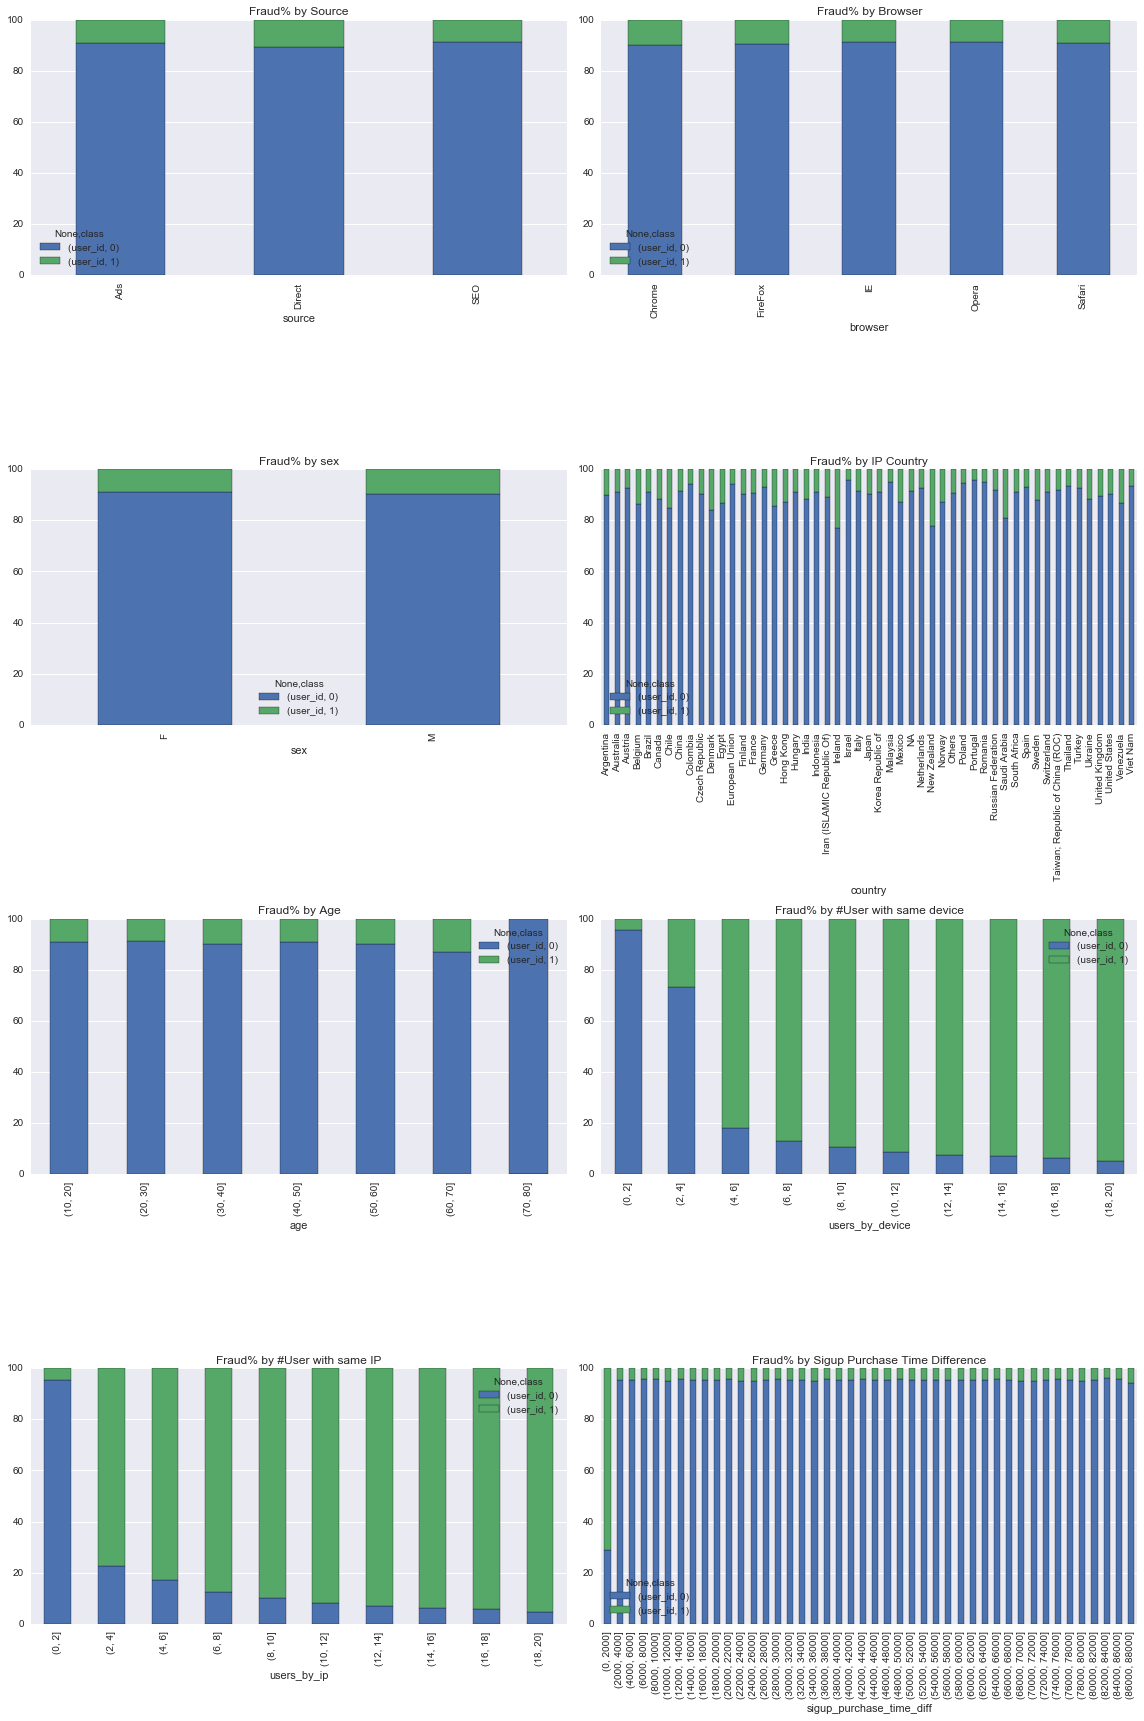

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(16, 24))
#fig.suptitle("Attributes Analysis", fontsize=16)

ax1 = plt.subplot("421")
ax1.set_title("Fraud% by Source")
var1 = fraud_data.groupby(['source','class']).agg({'user_id': 'count'})
var1_pct = var1.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var1_pct.unstack().plot(kind='bar',stacked=True,ax = ax1)

ax2 = plt.subplot("422")
ax2.set_title("Fraud% by Browser")
var2 = fraud_data.groupby(['browser','class']).agg({'user_id': 'count'})
var2_pct = var2.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var2_pct.unstack().plot(kind='bar',stacked=True, ax = ax2)

ax3 = plt.subplot("423")
ax3.set_title("Fraud% by sex")
var3 = fraud_data.groupby(['sex','class']).agg({'user_id': 'count'})
var3_pct = var3.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var3_pct.unstack().plot(kind='bar',stacked=True, ax = ax3)

ax4 = plt.subplot("424")
ax4.set_title("Fraud% by IP Country")
var4 = fraud_data.groupby(['country','class']).agg({'user_id': 'count'})
var4_pct = var4.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var4_pct.unstack().plot(kind='bar',stacked=True, ax = ax4)


ax5 = plt.subplot("425")
ax5.set_title("Fraud% by Age")
var5 = fraud_data.groupby([pd.cut(fraud_data["age"], np.arange(0, 100, 10)),'class']).agg({'user_id': 'count'})
var5_pct = var5.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var5_pct.unstack().plot(kind='bar',stacked=True, ax = ax5)


ax6 = plt.subplot("426")
ax6.set_title("Fraud% by #User with same device")
var6 = fraud_data.groupby([pd.cut(fraud_data["users_by_device"], np.arange(0, 50, 2)),'class']).agg({'user_id': 'count'})
var6_pct = var6.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var6_pct.unstack().plot(kind='bar',stacked=True, ax = ax6)

ax7 = plt.subplot("427")
ax7.set_title("Fraud% by #User with same IP")
var7 = fraud_data.groupby([pd.cut(fraud_data["users_by_ip"], np.arange(0, 50, 2)),'class']).agg({'user_id': 'count'})
var7_pct = var7.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var7_pct.unstack().plot(kind='bar',stacked=True, ax = ax7)

ax8 = plt.subplot("428")
ax8.set_title("Fraud% by Sigup Purchase Time Difference")
var8 = fraud_data.groupby([pd.cut(fraud_data["sigup_purchase_time_diff"], np.arange(0, 100000, 2000)),'class']).agg({'user_id': 'count'})
var8_pct = var8.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var8_pct.unstack().plot(kind='bar',stacked=True, ax = ax8)

fig.tight_layout()

plt.show()



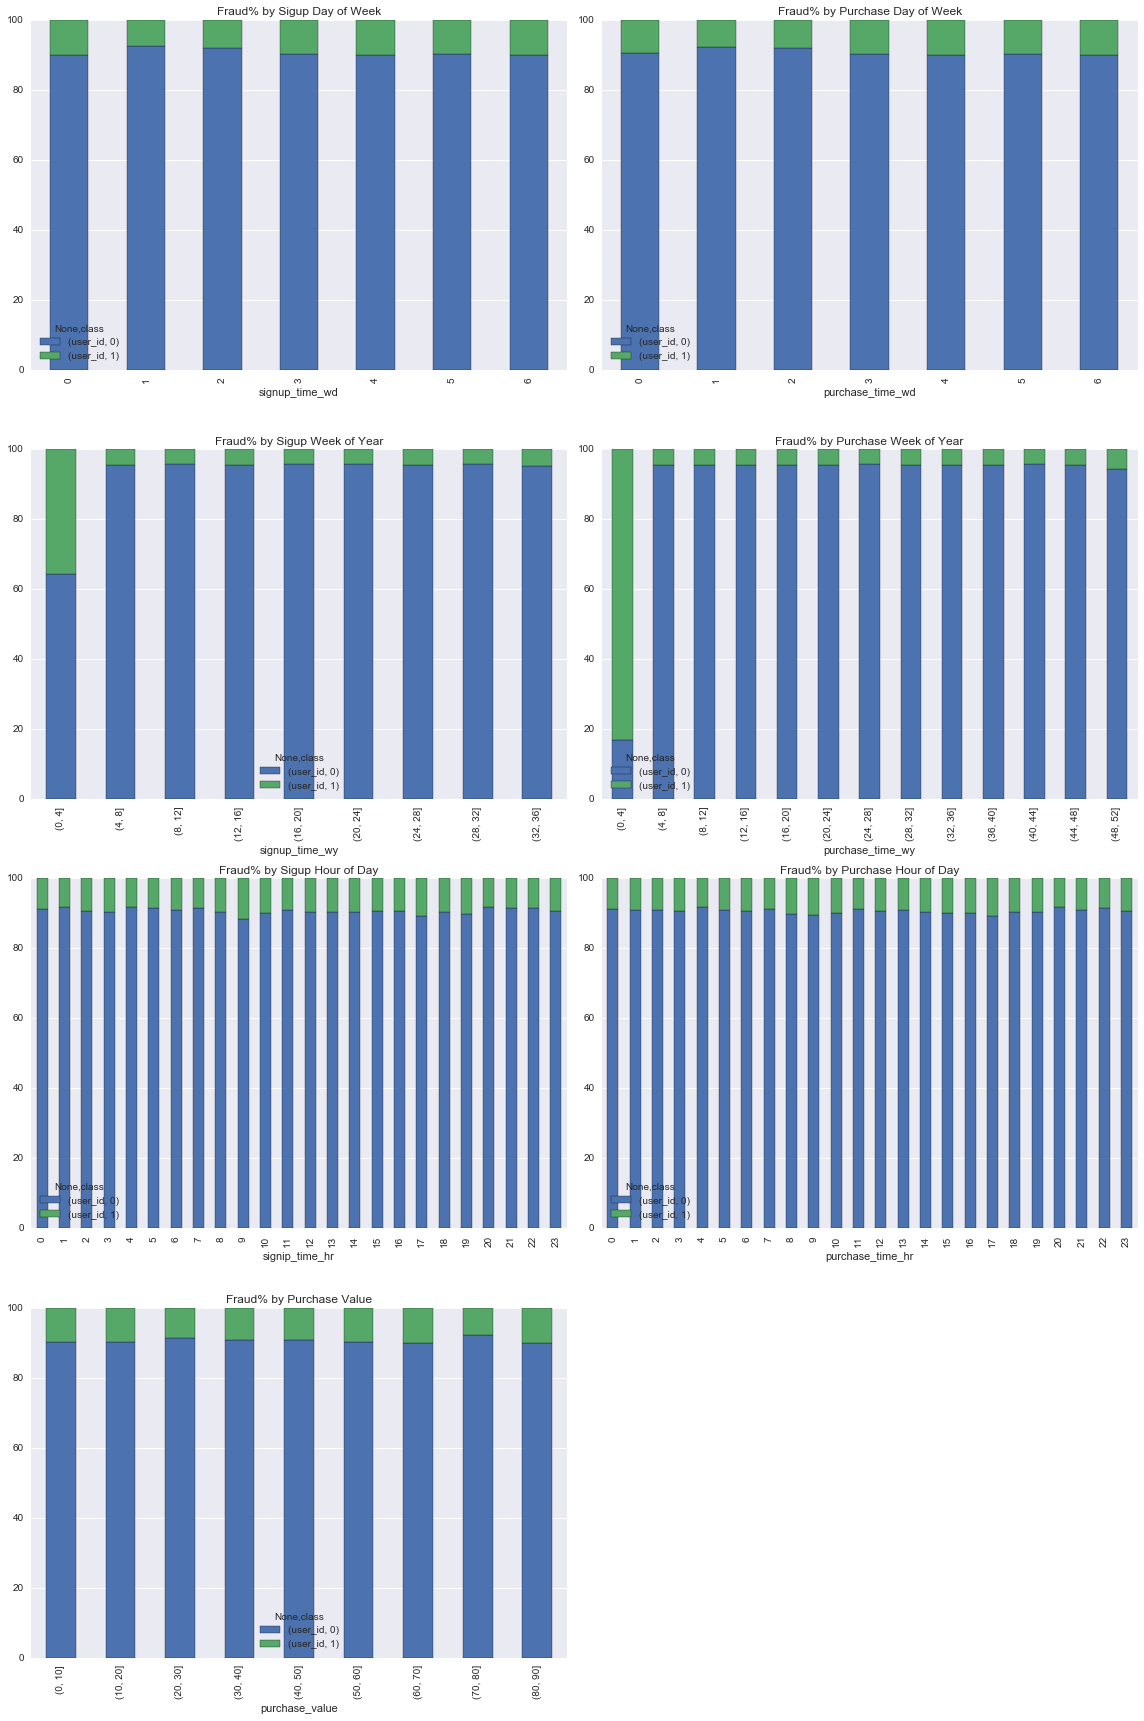

In [14]:
fig = plt.figure(figsize=(16, 20))

ax1 = plt.subplot("421")
ax1.set_title("Fraud% by Sigup Day of Week")
var1 = fraud_data.groupby(['signup_time_wd','class']).agg({'user_id': 'count'})
var1_pct = var1.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var1_pct.unstack().plot(kind='bar',stacked=True, ax = ax1)

ax2 = plt.subplot("422")
ax2.set_title("Fraud% by Purchase Day of Week")
var2 = fraud_data.groupby(['purchase_time_wd','class']).agg({'user_id': 'count'})
var2_pct = var2.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var2_pct.unstack().plot(kind='bar',stacked=True, ax = ax2)

ax3 = plt.subplot("423")
ax3.set_title("Fraud% by Sigup Week of Year")
var3 = fraud_data.groupby([pd.cut(fraud_data["signup_time_wy"], np.arange(0, 56, 4)),'class']).agg({'user_id': 'count'})
var3_pct = var3.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var3_pct.unstack().plot(kind='bar',stacked=True, ax = ax3)

ax4 = plt.subplot("424")
ax4.set_title("Fraud% by Purchase Week of Year")
var4 = fraud_data.groupby([pd.cut(fraud_data["purchase_time_wy"], np.arange(0, 56, 4)),'class']).agg({'user_id': 'count'})
var4_pct = var4.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var4_pct.unstack().plot(kind='bar',stacked=True, ax = ax4)

ax5 = plt.subplot("425")
ax5.set_title("Fraud% by Sigup Hour of Day")
var5 = fraud_data.groupby(["signip_time_hr",'class']).agg({'user_id': 'count'})
var5_pct = var5.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var5_pct.unstack().plot(kind='bar',stacked=True, ax = ax5)

ax6 = plt.subplot("426")
ax6.set_title("Fraud% by Purchase Hour of Day")
var6 = fraud_data.groupby(["purchase_time_hr",'class']).agg({'user_id': 'count'})
var6_pct = var6.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var6_pct.unstack().plot(kind='bar',stacked=True, ax = ax6)


ax7 = plt.subplot("427")
ax7.set_title("Fraud% by Purchase Value")
var7 = fraud_data.groupby([pd.cut(fraud_data["purchase_value"], np.arange(0, 100, 10)),'class']).agg({'user_id': 'count'})
var7_pct = var7.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var7_pct.unstack().plot(kind='bar',stacked=True, ax = ax7)

fig.tight_layout()

plt.show()


## Random shuffle and trop unuseful vaiables

In [6]:
#fill nan data
variable_drop_list = ['user_id', 'signup_time', 'purchase_time','device_id','ip_address','class']
#Fill NAN data
for columns in fraud_data.columns:
    if fraud_data[columns].isnull().any().any():
        print columns
        
for column in fraud_data.columns:
    if fraud_data[column].isnull().any().any() and column not in variable_drop_list:
        if fraud_data[column].dtype != object and fraud_data[column].dtype != float:
            temp_value = int(fraud_data[column].mean(skipna=True, axis=0))
            fraud_data[column].fillna(temp_value, inplace=True)
            print 'none_float columns',column
        elif fraud_data[column].dtype == float:
            temp_value = fraud_data[column].mean(skipna=True, axis=0)        
            fraud_data[column].fillna(temp_value, inplace=True) 
            print 'float columns',column

print "Finish fill Nan data"

Finish fill Nan data


In [7]:
# RANDOM SHUFFLE DATA
fraud_data_final = fraud_data.iloc[np.random.permutation(len(fraud_data))]
fraud_data_final.index = range(len(fraud_data_final))

#drop text and unuseful field
target = fraud_data_final['class']
target = [np.int(x) for x in target]

fraud_data_final.drop(variable_drop_list, axis=1, inplace=True)

print "finished pre-processing data"

finished pre-processing data


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Cause python sklearn naturally not accept Nan input, I will fill any Nan with variable mean. 

## Processs character variable and do Train/test data split

In [8]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(fraud_data_final)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (72 total features):
['purchase_value', 'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M', 'age', 'country_Argentina', 'country_Australia', 'country_Austria', 'country_Belgium', 'country_Brazil', 'country_Canada', 'country_Chile', 'country_China', 'country_Colombia', 'country_Czech Republic', 'country_Denmark', 'country_Egypt', 'country_European Union', 'country_Finland', 'country_France', 'country_Germany', 'country_Greece', 'country_Hong Kong', 'country_Hungary', 'country_India', 'country_Indonesia', 'country_Iran (ISLAMIC Republic Of)', 'country_Ireland', 'country_Israel', 'country_Italy', 'country_Japan', 'country_Korea Republic of', 'country_Malaysia', 'country_Mexico', 'country_NA', 'country_Netherlands', 'country_New Zealand', 'country_Norway', 'country_Others', 'country_Poland', 'country_Portugal', 'country_Romania', 'country_Russian Federation', 'country_

## Modeling and parameter tunning

In [44]:
# Random forest without imbalance data resample
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score,mean_squared_error

randomforest = RandomForestClassifier(random_state=24,n_estimators=100,oob_score=True)
tree_score = make_scorer(f1_score, greater_is_better=True)

parameters = {'max_depth':[x for x in range(2,21)]}

clf_rf = grid_search.GridSearchCV(estimator=randomforest, param_grid=parameters, cv=5, scoring=tree_score)

clf_rf.fit(X_all,target)

print "Random Forest best parameter", clf_rf.best_estimator_
print "Random Forest Out Of BAG best score", clf_rf.best_score_  
print "Random Forest Accuracy:", accuracy_score(target,clf_rf.predict(X_all))  
print 'finish Random Forest Train'

print "RandomForestClassifier F1 score on original data",f1_score(target,clf_rf.predict(X_all))
print "RandomForestClassifier accuracy score on original data",accuracy_score(target,clf_rf.predict(X_all))

Random Forest best parameter RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=24, verbose=0, warm_start=False)
Random Forest Out Of BAG best score 0.697940771302
Random Forest Accuracy: 0.956555402615
finish Random Forest Train
RandomForestClassifier F1 score on original data 0.69836894096
RandomForestClassifier accuracy score on original data 0.956555402615


### Try oversampling

In [37]:
#deal with unbalanced data
from imblearn.over_sampling import RandomOverSampler
ro = RandomOverSampler()
X_resampled_ros, y_resampled_ros = ro.fit_sample(X_all, target)
X_resampled_ros = pd.DataFrame(X_resampled_ros,columns = X_all.columns)

print "resample unbalanced data finished"

resample unbalanced data finished


In [42]:
#RANDOM FOREST USING RANDOM OVER SAMPLING
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()

randomforest = RandomForestClassifier(random_state=24, n_estimators=100)

# USE MSE AS SCORE FUNCTION
tree_score = make_scorer(f1_score, greater_is_better=True)

score_record = pd.DataFrame(columns=['max_depth', 'f1_score', 'accuracy_score'])

kf = cross_validation.KFold(len(X_all), n_folds=5)

target_ros = pd.DataFrame(target,columns = ['class'])
target_ros.index = range(len(target))

for max_depth in range(2,45):
    print "running on max_depth:=", max_depth
    avg_f1_score = 0.0
    avg_accu_score = 0.0    
    for train, test in kf:
        X_train, X_test, Y_train, Y_test = X_all.iloc[train], X_all.iloc[test], target_ros.iloc[train], target_ros.iloc[test]
        X_resampled, y_resampled = ros.fit_sample(X_train, Y_train)           
        clf = RandomForestClassifier(random_state=24, 
                                     n_estimators=100, 
                                     max_depth = max_depth
                                    )
        clf.fit(X_resampled, y_resampled)
        avg_f1_score += f1_score(Y_test,clf.predict(X_test))
        avg_accu_score += accuracy_score(Y_test,clf.predict(X_test))    
    print "F1 Score is :=", avg_f1_score/5.0, "; Accuracy Score is :=", avg_accu_score/5.0                           
    score_record = score_record.append(pd.DataFrame([[max_depth,avg_f1_score/5.0,avg_accu_score/5.0]],
                                                    columns=['max_depth', 'f1_score', 'accuracy_score']))

score_record[score_record.f1_score == score_record.f1_score.max()]
best_estimation = score_record[score_record.f1_score == score_record.f1_score.max()]

print "best Out Of BAG max_depth", best_estimation.max_depth[0]
print "best Out Of BAG f1 score", best_estimation.f1_score[0]
print "best Out Of BAG accuracy_score", best_estimation.accuracy_score[0]

print('finished modeling')

best Out Of BAG max_depth 40.0
best Out Of BAG f1 score 0.698346144572
best Out Of BAG accuracy_score 0.955781150379
finished modeling


In [43]:
clf_rf_ros = RandomForestClassifier(random_state=24, 
                                    n_estimators=100, 
                                    max_depth = 40
                                   )
clf_rf_ros.fit(X_resampled_ros, y_resampled_ros)

print "RandomForestClassifier F1 score on oversampled data", f1_score(y_resampled_ros,clf_rf_ros.predict(X_resampled_ros))
print "RandomForestClassifier accuracy score on oversampled data",accuracy_score(y_resampled_ros,clf_rf_ros.predict(X_resampled_ros))
print "RandomForestClassifier F1 score on original data",f1_score(target,clf_rf_ros.predict(X_all))
print "RandomForestClassifier accuracy score on original data",accuracy_score(target,clf_rf_ros.predict(X_all))

RandomForestClassifier F1 score on oversampled data 1.0
RandomForestClassifier accuracy score on oversampled data 1.0
RandomForestClassifier F1 score on original data 1.0
RandomForestClassifier accuracy score on original data 1.0


### Oversampling with SMOTE

In [51]:
#deal with unbalanced data
from imblearn.over_sampling import SMOTE
ro = SMOTE()
X_resampled_smote, y_resampled_smote = ro.fit_sample(X_all, target)
X_resampled_smote = pd.DataFrame(X_resampled_smote,columns = X_all.columns)

print "resample unbalanced data finished"

resample unbalanced data finished


In [57]:
#RANDOM FOREST USING RANDOM OVER SAMPLING WITH 
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
smotes = SMOTE()

randomforest = RandomForestClassifier(random_state=24, n_estimators=100)

# USE MSE AS SCORE FUNCTION
tree_score = make_scorer(f1_score, greater_is_better=True)

score_record = pd.DataFrame(columns=['max_depth', 'f1_score', 'accuracy_score'])

kf = cross_validation.KFold(len(X_all), n_folds=5)

target_ros = pd.DataFrame(target,columns = ['class'])
target_ros.index = range(len(target))

for max_depth in range(20,22,1):
    print "running on max_depth:=", max_depth
    avg_f1_score = 0.0
    avg_accu_score = 0.0    
    for train, test in kf:
        X_train, X_test, Y_train, Y_test = X_all.iloc[train], X_all.iloc[test], target_ros.iloc[train], target_ros.iloc[test]
        X_resampled, y_resampled = smotes.fit_sample(X_train, Y_train)           
        clf = RandomForestClassifier(random_state=24, 
                                     n_estimators=100, 
                                     max_depth = max_depth
                                    )
        clf.fit(X_resampled, y_resampled)
        avg_f1_score += f1_score(Y_test,clf.predict(X_test))
        avg_accu_score += accuracy_score(Y_test,clf.predict(X_test))    
    print "F1 Score is :=", avg_f1_score/5.0, "; Accuracy Score is :=", avg_accu_score/5.0                           
    score_record = score_record.append(pd.DataFrame([[max_depth,avg_f1_score/5.0,avg_accu_score/5.0]],
                                                    columns=['max_depth', 'f1_score', 'accuracy_score']))

score_record[score_record.f1_score == score_record.f1_score.max()]
best_estimation = score_record[score_record.f1_score == score_record.f1_score.max()]

print "best Out Of BAG max_depth", best_estimation.max_depth[0]
print "best Out Of BAG f1 score", best_estimation.f1_score[0]
print "best Out Of BAG accuracy_score", best_estimation.accuracy_score[0]

print('finished modeling')

best Out Of BAG max_depth 20.0
best Out Of BAG f1 score 0.699216269179
best Out Of BAG accuracy_score 0.95657526642
finished modeling


In [58]:
clf_rf_smote = RandomForestClassifier(random_state=24, 
                                    n_estimators=100, 
                                    max_depth = 20
                                   )
clf_rf_smote.fit(X_resampled_smote, y_resampled_smote)

print "RandomForestClassifier F1 score on oversampled SMOTE data", f1_score(y_resampled_smote,clf_rf_smote.predict(X_resampled_smote))
print "RandomForestClassifier accuracy score on oversampled SMOTE data",accuracy_score(y_resampled_smote,clf_rf_smote.predict(X_resampled_smote))
print "RandomForestClassifier F1 score on original data",f1_score(target,clf_rf_smote.predict(X_all))
print "RandomForestClassifier accuracy score on original data",accuracy_score(target,clf_rf_smote.predict(X_all))

RandomForestClassifier F1 score on oversampled SMOTE data 0.978215620594
RandomForestClassifier accuracy score on oversampled SMOTE data 0.978680062207
RandomForestClassifier F1 score on original data 0.758302987759
RandomForestClassifier accuracy score on original data 0.963543596802


### Try undersampling

In [45]:
#deal with unbalanced data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_resampled_rus, y_resampled_rus = rus.fit_sample(X_all, target)
X_resampled_rus = pd.DataFrame(X_resampled_rus,columns = X_all.columns)

print "resample unbalanced data finished"

resample unbalanced data finished


In [47]:
#RANDOM FOREST USING RANDOM OVER SAMPLING
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()

randomforest = RandomForestClassifier(random_state=24, n_estimators=100)

# USE MSE AS SCORE FUNCTION
tree_score = make_scorer(f1_score, greater_is_better=True)

score_record = pd.DataFrame(columns=['max_depth', 'f1_score', 'accuracy_score'])

kf = cross_validation.KFold(len(X_all), n_folds=5)

target_ros = pd.DataFrame(target,columns = ['class'])
target_ros.index = range(len(target))

for max_depth in range(3,30):
    print "running on max_depth:=", max_depth
    avg_f1_score = 0.0
    avg_accu_score = 0.0    
    for train, test in kf:
        X_train, X_test, Y_train, Y_test = X_all.iloc[train], X_all.iloc[test], target_ros.iloc[train], target_ros.iloc[test]
        X_resampled, y_resampled = rus.fit_sample(X_train, Y_train)           
        clf = RandomForestClassifier(random_state=24, 
                                     n_estimators=100, 
                                     max_depth = max_depth
                                    )
        clf.fit(X_resampled, y_resampled)
        avg_f1_score += f1_score(Y_test,clf.predict(X_test))
        avg_accu_score += accuracy_score(Y_test,clf.predict(X_test))    
    print "F1 Score is :=", avg_f1_score/5.0, "; Accuracy Score is :=", avg_accu_score/5.0                           
    score_record = score_record.append(pd.DataFrame([[max_depth,avg_f1_score/5.0,avg_accu_score/5.0]],
                                                    columns=['max_depth', 'f1_score', 'accuracy_score']))

score_record[score_record.f1_score == score_record.f1_score.max()]
best_estimation = score_record[score_record.f1_score == score_record.f1_score.max()]

print "best Out Of BAG max_depth", best_estimation.max_depth[0]
print "best Out Of BAG f1 score", best_estimation.f1_score[0]
print "best Out Of BAG accuracy_score", best_estimation.accuracy_score[0]

print('finished modeling')

best Out Of BAG max_depth 3.0
best Out Of BAG f1 score 0.653045146465
best Out Of BAG accuracy_score 0.940031292069
finished modeling


In [50]:
clf_rf_rus = RandomForestClassifier(random_state=24, 
                                    n_estimators=100, 
                                    max_depth = 3
                                   )
clf_rf_rus.fit(X_resampled_rus, y_resampled_rus)

print "RandomForestClassifier F1 score on undersampled data", f1_score(y_resampled_rus,clf_rf_rus.predict(X_resampled_rus))
print "RandomForestClassifier accuracy score on undersampled data",accuracy_score(y_resampled_rus,clf_rf_rus.predict(X_resampled_rus))
print "RandomForestClassifier F1 score on original data",f1_score(target,clf_rf_rus.predict(X_all))
print "RandomForestClassifier accuracy score on original data",accuracy_score(target,clf_rf_rus.predict(X_all))

RandomForestClassifier F1 score on undersampled data 0.760205802969
RandomForestClassifier accuracy score on undersampled data 0.799095470285
RandomForestClassifier F1 score on original data 0.631272981965
RandomForestClassifier accuracy score on original data 0.930323203981


## ROC Curve

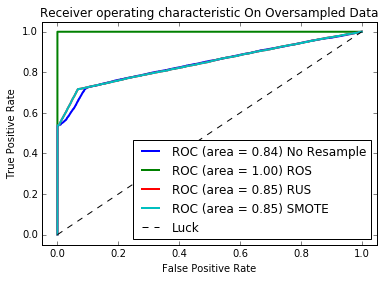

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score1 = clf_rf.predict_proba(X_all)#ROC for RF without resampling
y_score2 = clf_rf_ros.predict_proba(X_all)#ROC for RF with ROS
y_score3 = clf_rf_rus.predict_proba(X_all)#ROC for RF with RUS
y_score4 = clf_rf_smote.predict_proba(X_all)#ROC for RF with SMOTE

# Compute ROC curve and ROC area for each class
fpr1, tpr1, thresholds1 = roc_curve(target, y_score1[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(target, y_score2[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(target, y_score3[:, 1])
fpr4, tpr4, thresholds4 = roc_curve(target, y_score3[:, 1])


# Compute micro-average ROC curve and ROC area
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

plt.plot(fpr1, tpr1, lw=2, 
         label='ROC (area = %0.2f) No Resample' %  roc_auc1)
plt.plot(fpr2, tpr2, lw=2, 
         label='ROC (area = %0.2f) ROS' %  roc_auc2)    
plt.plot(fpr3, tpr3, lw=2, 
         label='ROC (area = %0.2f) RUS' %  roc_auc3)    
plt.plot(fpr3, tpr3, lw=2, 
         label='ROC (area = %0.2f) SMOTE' %  roc_auc4)    
       
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k',
         label='Luck')
    
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic On Oversampled Data')
plt.legend(loc="lower right")
plt.show()

Note: ROS is overfitted in graphs

In [60]:
rf_roc = pd.DataFrame(fpr4,columns=['FPR'])
rf_roc['TPR'] = tpr4
rf_roc['Threshold'] = thresholds4

rf_roc['distance'] = rf_roc['FPR']**2 + (1.0- rf_roc['TPR'])**2

min_value = rf_roc['distance'].min()

print "best cut off point"
display(rf_roc[rf_roc.distance == min_value])

best cut off point


,FPR,TPR,Threshold,distance
5058,0.092311,0.724472,0.361834,0.084437
